In [91]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
# -*- coding: utf-8 -*-
"""
@author: Korey MacVittie

Used TA code as starting point.
"""

import functools
import io
import numpy as np
import sys
import numpy.lib.recfunctions as rfn
import time
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.model_selection import KFold  #EDIT: I had to import KFold 
from numpy import genfromtxt

import matplotlib.pyplot as plt

#if sys.version_info >= (3,):
#    np.genfromtxt = genfromtxt_py3_fixed
  
#Read the two first two lines of the file.
with open('data\claim.sample.csv', 'r') as f:
    print(f.readline())
    print(f.readline())

"V1","Claim.Number","Claim.Line.Number","Member.ID","Provider.ID","Line.Of.Business.ID","Revenue.Code","Service.Code","Place.Of.Service.Code","Procedure.Code","Diagnosis.Code","Claim.Charge.Amount","Denial.Reason.Code","Price.Index","In.Out.Of.Network","Reference.Index","Pricing.Index","Capitation.Index","Subscriber.Payment.Amount","Provider.Payment.Amount","Group.Index","Subscriber.Index","Subgroup.Index","Claim.Type","Claim.Subscriber.Type","Claim.Pre.Prince.Index","Claim.Current.Status","Network.ID","Agreement.ID"

"1",28849991,1,9583423,"FA0001411002","0002","0128","RR8I"," "," ","V5789",19356.96," ","A","I","N","N","N",0,15036.21,110,7763000,0,"M","H"," ","02","P00000000002","FH001310QB01"



In [88]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
names = ["V1","Claim.Number","Claim.Line.Number",
         "Member.ID","Provider.ID","Line.Of.Business.ID",
         "Revenue.Code","Service.Code","Place.Of.Service.Code",
         "Procedure.Code","Diagnosis.Code","Claim.Charge.Amount",
         "Denial.Reason.Code","Price.Index","In.Out.Of.Network",
         "Reference.Index","Pricing.Index","Capitation.Index",
         "Subscriber.Payment.Amount","Provider.Payment.Amount",
         "Group.Index","Subscriber.Index","Subgroup.Index",
         "Claim.Type","Claim.Subscriber.Type","Claim.Pre.Prince.Index",
         "Claim.Current.Status","Network.ID","Agreement.ID"]

sys.setrecursionlimit(5500)

types = ['S8', 'f8', 'i4', 'i4', 'S14', 'S6', 'S6', 'S6', 'S4', 'S9', 'S7', 'f8',
         'S5', 'S3', 'S3', 'S3', 'S3', 'S3', 'f8', 'f8', 'i4', 'i4', 'i4', 'S3', 
         'S3', 'S3', 'S4', 'S14', 'S14']

In [3]:
CLAIMS = genfromtxt('data\claim.sample.csv', delimiter=',', names=True, dtype=types, 
                       usecols=[0,1,2,3,4,5,
                                6,7,8,9,10,11,
                                12,13,14,15,16,
                                17,18,19,20,21,
                                22,23,24,25,26,
                                27,28])

In [4]:
test = 'J'
test = test.encode()

JcodeIndexes = np.flatnonzero(np.core.defchararray.startswith(CLAIMS['ProcedureCode'], test, start=0, end=None)!=-1)

JcodeINDICES = np.core.defchararray.startswith(CLAIMS['ProcedureCode'], test, start=1, end=2)
Jcodes = CLAIMS[JcodeINDICES]

print(Jcodes)

print(Jcodes.dtype.names)

[(b'"3074"', 7.4645490e+07, 10,  1992052, b'"FA0001389001"', b'"0005"', b'"0636"', b'"OP7O"', b'" "', b'"J1650"', b'"4359"', 592.201995, b'"KAO"', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 0.,   114,  1613650,     0, b'"M"', b'"H"', b'"S"', b'"91"', b'"P00000000001"', b'"FH001309QB01"')
 (b'"3092"', 1.8860690e+07,  8, 22808129, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J2405"', b'"64303"', 118.83297 , b'"J2L"', b'"A"', b'"I"', b'"N"', b'"N"', b'"R"', 0., 0.,   275, 18475600,   483, b'"M"', b'"H"', b'" "', b'"02"', b'"H00000000001"', b'"FH001886QH01"')
 (b'"3093"', 1.8860690e+07,  9, 22808129, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J7030"', b'"64303"', 196.890405, b'"J2L"', b'"A"', b'"I"', b'"N"', b'"N"', b'"R"', 0., 0.,   275, 18475600,   483, b'"M"', b'"H"', b'" "', b'"02"', b'"H00000000001"', b'"FH001886QH01"')
 ...
 (b'"288476"', 4.0687899e+08,  5, 95251427, b'"FA0001387001"', b'" "', b'"0636"', b'"OP7O"', b'" "', b'"J7120"', b'"3669"',

In [5]:
#Sorted Jcodes, by ProviderPaymentAmount
Sorted_Jcodes = np.sort(Jcodes, order='ProviderPaymentAmount')


# Reverse the sorted Jcodes
Sorted_Jcodes = Sorted_Jcodes[::-1]
# [7, 6, 5, 4, 3, 2, 1]

# What are the top five J-codes based on the payment to providers?

# We still need to group the data
print(Sorted_Jcodes[:10])

[(b'"361700"', 1.20381690e+08,  9, 81274542, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 30541.53   , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 30541.53   , 48546, 65836000, 0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000002"', b'"A00BLCH0Q001"')
 (b'"361699"', 1.20381690e+08,  8, 81274542, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 30541.53   , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 30541.53   , 48546, 65836000, 0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000002"', b'"A00BLCH0Q001"')
 (b'"356744"', 1.20454790e+08,  5, 81041406, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 29745.2775 , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 29745.2775 , 48546, 65647150, 0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000001"', b'"A00BLCH0Q001"')
 (b'"165695"', 6.83342990e+08,  1,  1987669, b'"FA0001387002"', b'"0005"', b'"0250"', b'"OP7O"', b'" "', b'"J

In [6]:
# You can subset it...
ProviderPayments = Sorted_Jcodes['ProviderPaymentAmount']
Jcodes = Sorted_Jcodes['ProcedureCode']

#recall their data types
Jcodes.dtype
ProviderPayments.dtype

Jcodes[:3]

ProviderPayments[:3]



#Join arrays together
arrays = [Jcodes, ProviderPayments]

#https://www.numpy.org/devdocs/user/basics.rec.html
Jcodes_with_ProviderPayments = rfn.merge_arrays(arrays, flatten = True, usemask = False)

# What does the result look like?
print(Jcodes_with_ProviderPayments[:3])

Jcodes_with_ProviderPayments.shape

[(b'"J9310"', 30541.53  ) (b'"J9310"', 30541.53  )
 (b'"J9310"', 29745.2775)]


(51029,)

In [7]:
#http://esantorella.com/2016/06/16/groupby/
#A fast GroupBy class
class Groupby:
    def __init__(self, keys):
        _, self.keys_as_int = np.unique(keys, return_inverse = True)
        self.n_keys = max(self.keys_as_int)
        self.set_indices()
        
    def set_indices(self):
        self.indices = [[] for i in range(self.n_keys+1)]
        for i, k in enumerate(self.keys_as_int):
            self.indices[k].append(i)
        self.indices = [np.array(elt) for elt in self.indices]
        
    def apply(self, function, vector, broadcast):
        if broadcast:
            result = np.zeros(len(vector))
            for idx in self.indices:
                result[idx] = function(vector[idx])
        else:
            result = np.zeros(self.n_keys)
            for k, idx in enumerate(self.indices):
                result[self.keys_as_int[k]] = function(vector[idx])

        return result

In [9]:
#perform the groupby to get the group sums
group_sums = Groupby(Jcodes).apply(np.sum, ProviderPayments, broadcast=False)

group_sums.shape

np.set_printoptions(threshold=500, suppress=True)
print(group_sums)

#How do we get the JCodes for the group sums?
#Look up at the class Groupby
unique_keys, indices = np.unique(Jcodes, return_inverse = True)

print(unique_keys)
print(indices)

len(unique_keys)
len(group_sums)    

print(group_sums)

#Zip it and sort it.
zipped = zip(unique_keys, group_sums)  # python 3
sorted_group_sums = sorted(zipped, key=lambda x: x[1])

print(sorted_group_sums)

print(Sorted_Jcodes.dtype.names)

##We need to come up with labels for paid and unpaid Jcodes

## find unpaid row indexes  

unpaid_mask = (Sorted_Jcodes['ProviderPaymentAmount'] == 0)

## find paid row indexes
paid_mask = (Sorted_Jcodes['ProviderPaymentAmount'] > 0)


#Here are our
Unpaid_Jcodes = Sorted_Jcodes[unpaid_mask]

Paid_Jcodes = Sorted_Jcodes[paid_mask]

#These are still structured numpy arrays
print(Unpaid_Jcodes.dtype.names)
print(Unpaid_Jcodes[0])

print(Paid_Jcodes.dtype.names)
print(Paid_Jcodes[0])

#Now I need to create labels


print(Paid_Jcodes.dtype.descr)
print(Unpaid_Jcodes.dtype.descr)

#create a new column and data type for both structured arrays
new_dtype1 = np.dtype(Unpaid_Jcodes.dtype.descr + [('IsUnpaid', '<i4')])
new_dtype2 = np.dtype(Paid_Jcodes.dtype.descr + [('IsUnpaid', '<i4')])

print(new_dtype1)
print(new_dtype2)

#create new structured array with labels

#first get the right shape for each.
Unpaid_Jcodes_w_L = np.zeros(Unpaid_Jcodes.shape, dtype=new_dtype1)
Paid_Jcodes_w_L = np.zeros(Paid_Jcodes.shape, dtype=new_dtype2)

#check the shape
Unpaid_Jcodes_w_L.shape
Paid_Jcodes_w_L.shape

#Look at the data
print(Unpaid_Jcodes_w_L)
print(Paid_Jcodes_w_L)

[     0.        13386.88097       0.            0.            0.
      0.            0.            0.            0.            0.
   1185.724975      0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.          364.1898
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
   3482.549175    787.611         0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0

In [10]:
#copy the data
Unpaid_Jcodes_w_L['V1'] = Unpaid_Jcodes['V1']
Unpaid_Jcodes_w_L['ClaimNumber'] = Unpaid_Jcodes['ClaimNumber']
Unpaid_Jcodes_w_L['ClaimLineNumber'] = Unpaid_Jcodes['ClaimLineNumber']
Unpaid_Jcodes_w_L['MemberID'] = Unpaid_Jcodes['MemberID']
Unpaid_Jcodes_w_L['ProviderID'] = Unpaid_Jcodes['ProviderID']
Unpaid_Jcodes_w_L['LineOfBusinessID'] = Unpaid_Jcodes['LineOfBusinessID']
Unpaid_Jcodes_w_L['RevenueCode'] = Unpaid_Jcodes['RevenueCode']
Unpaid_Jcodes_w_L['ServiceCode'] = Unpaid_Jcodes['ServiceCode']
Unpaid_Jcodes_w_L['PlaceOfServiceCode'] = Unpaid_Jcodes['PlaceOfServiceCode']
Unpaid_Jcodes_w_L['ProcedureCode'] = Unpaid_Jcodes['ProcedureCode']
Unpaid_Jcodes_w_L['DiagnosisCode'] = Unpaid_Jcodes['DiagnosisCode']
Unpaid_Jcodes_w_L['ClaimChargeAmount'] = Unpaid_Jcodes['ClaimChargeAmount']
Unpaid_Jcodes_w_L['DenialReasonCode'] = Unpaid_Jcodes['DenialReasonCode']
Unpaid_Jcodes_w_L['PriceIndex'] = Unpaid_Jcodes['PriceIndex']
Unpaid_Jcodes_w_L['InOutOfNetwork'] = Unpaid_Jcodes['InOutOfNetwork']
Unpaid_Jcodes_w_L['ReferenceIndex'] = Unpaid_Jcodes['ReferenceIndex']
Unpaid_Jcodes_w_L['PricingIndex'] = Unpaid_Jcodes['PricingIndex']
Unpaid_Jcodes_w_L['CapitationIndex'] = Unpaid_Jcodes['CapitationIndex']
Unpaid_Jcodes_w_L['SubscriberPaymentAmount'] = Unpaid_Jcodes['SubscriberPaymentAmount']
Unpaid_Jcodes_w_L['ProviderPaymentAmount'] = Unpaid_Jcodes['ProviderPaymentAmount']
Unpaid_Jcodes_w_L['GroupIndex'] = Unpaid_Jcodes['GroupIndex']
Unpaid_Jcodes_w_L['SubscriberIndex'] = Unpaid_Jcodes['SubscriberIndex']
Unpaid_Jcodes_w_L['SubgroupIndex'] = Unpaid_Jcodes['SubgroupIndex']
Unpaid_Jcodes_w_L['ClaimType'] = Unpaid_Jcodes['ClaimType']
Unpaid_Jcodes_w_L['ClaimSubscriberType'] = Unpaid_Jcodes['ClaimSubscriberType']
Unpaid_Jcodes_w_L['ClaimPrePrinceIndex'] = Unpaid_Jcodes['ClaimPrePrinceIndex']
Unpaid_Jcodes_w_L['ClaimCurrentStatus'] = Unpaid_Jcodes['ClaimCurrentStatus']
Unpaid_Jcodes_w_L['NetworkID'] = Unpaid_Jcodes['NetworkID']
Unpaid_Jcodes_w_L['AgreementID'] = Unpaid_Jcodes['AgreementID']

#And assign the target label 
Unpaid_Jcodes_w_L['IsUnpaid'] = 1

#Look at the data..
print(Unpaid_Jcodes_w_L)

[(b'"99999"', 8.7604679e+08,  5, 48360179, b'"FA0001389001"', b'"0001"', b'"0636"', b'"SU7A"', b'" "', b'"J3010"', b'"2113"', 264.664455, b'" "', b'"A"', b'"I"', b'"V"', b'"V"', b'"N"', 0., 0., 572, 39173900, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 (b'"99998"', 8.7604679e+08,  4, 48360179, b'"FA0001389001"', b'"0001"', b'"0636"', b'"SU7A"', b'" "', b'"J2250"', b'"2113"', 337.85796 , b'" "', b'"A"', b'"I"', b'"V"', b'"N"', b'"N"', 0., 0., 572, 39173900, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 (b'"99992"', 8.7607029e+08,  5, 42728206, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J7120"', b'"V7651"', 269.07162 , b'" "', b'"A"', b'"I"', b'"V"', b'"N"', b'"N"', 0., 0., 572, 34611750, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 ...
 (b'"100023"', 8.7605619e+08, 17, 30332530, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J1170"', b'"5589"', 120.80817

In [11]:
# Do the same for the Paid set.

#copy the data
Paid_Jcodes_w_L['V1'] = Paid_Jcodes['V1']
Paid_Jcodes_w_L['ClaimNumber'] = Paid_Jcodes['ClaimNumber']
Paid_Jcodes_w_L['ClaimLineNumber'] = Paid_Jcodes['ClaimLineNumber']
Paid_Jcodes_w_L['MemberID'] = Paid_Jcodes['MemberID']
Paid_Jcodes_w_L['ProviderID'] = Paid_Jcodes['ProviderID']
Paid_Jcodes_w_L['LineOfBusinessID'] = Paid_Jcodes['LineOfBusinessID']
Paid_Jcodes_w_L['RevenueCode'] = Paid_Jcodes['RevenueCode']
Paid_Jcodes_w_L['ServiceCode'] = Paid_Jcodes['ServiceCode']
Paid_Jcodes_w_L['PlaceOfServiceCode'] = Paid_Jcodes['PlaceOfServiceCode']
Paid_Jcodes_w_L['ProcedureCode'] = Paid_Jcodes['ProcedureCode']
Paid_Jcodes_w_L['DiagnosisCode'] = Paid_Jcodes['DiagnosisCode']
Paid_Jcodes_w_L['ClaimChargeAmount'] = Paid_Jcodes['ClaimChargeAmount']
Paid_Jcodes_w_L['DenialReasonCode'] = Paid_Jcodes['DenialReasonCode']
Paid_Jcodes_w_L['PriceIndex'] = Paid_Jcodes['PriceIndex']
Paid_Jcodes_w_L['InOutOfNetwork'] = Paid_Jcodes['InOutOfNetwork']
Paid_Jcodes_w_L['ReferenceIndex'] = Paid_Jcodes['ReferenceIndex']
Paid_Jcodes_w_L['PricingIndex'] = Paid_Jcodes['PricingIndex']
Paid_Jcodes_w_L['CapitationIndex'] = Paid_Jcodes['CapitationIndex']
Paid_Jcodes_w_L['SubscriberPaymentAmount'] = Paid_Jcodes['SubscriberPaymentAmount']
Paid_Jcodes_w_L['ProviderPaymentAmount'] = Paid_Jcodes['ProviderPaymentAmount']
Paid_Jcodes_w_L['GroupIndex'] = Paid_Jcodes['GroupIndex']
Paid_Jcodes_w_L['SubscriberIndex'] = Paid_Jcodes['SubscriberIndex']
Paid_Jcodes_w_L['SubgroupIndex'] = Paid_Jcodes['SubgroupIndex']
Paid_Jcodes_w_L['ClaimType'] = Paid_Jcodes['ClaimType']
Paid_Jcodes_w_L['ClaimSubscriberType'] = Paid_Jcodes['ClaimSubscriberType']
Paid_Jcodes_w_L['ClaimPrePrinceIndex'] = Paid_Jcodes['ClaimPrePrinceIndex']
Paid_Jcodes_w_L['ClaimCurrentStatus'] = Paid_Jcodes['ClaimCurrentStatus']
Paid_Jcodes_w_L['NetworkID'] = Paid_Jcodes['NetworkID']
Paid_Jcodes_w_L['AgreementID'] = Paid_Jcodes['AgreementID']

#And assign the target label 
Paid_Jcodes_w_L['IsUnpaid'] = 0

#Look at the data..
print(Paid_Jcodes_w_L)

[(b'"361700"', 1.2038169e+08, 9, 81274542, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 30541.53    , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 30541.53    , 48546, 65836000,     0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000002"', b'"A00BLCH0Q001"', 0)
 (b'"361699"', 1.2038169e+08, 8, 81274542, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 30541.53    , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 30541.53    , 48546, 65836000,     0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000002"', b'"A00BLCH0Q001"', 0)
 (b'"356744"', 1.2045479e+08, 5, 81041406, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 29745.2775  , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 29745.2775  , 48546, 65647150,     0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000001"', b'"A00BLCH0Q001"', 0)
 ...
 (b'"347380"', 1.1512179e+08, 3, 94931877, b'"FA1000014001"', b'"0013"', b'"0637"',

In [12]:
#now combine the rows together (axis=0)
Jcodes_w_L = np.concatenate((Unpaid_Jcodes_w_L, Paid_Jcodes_w_L), axis=0)

#check the shape
Jcodes_w_L.shape

#44961 + 6068

#look at the transition between the rows around row 44961
print(Jcodes_w_L[44960:44963])

#We need to shuffle the rows before using classifers in sklearn

Jcodes_w_L.dtype.names

[(b'"100000"', 8.7604679e+08, 6, 48360179, b'"FA0001389001"', b'"0001"', b'"0636"', b'"SU7A"', b'" "', b'"J7120"', b'"2113"',   269.07162, b'" "', b'"A"', b'"I"', b'"V"', b'"N"', b'"N"', 0.,     0.  ,   572, 39173900, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 (b'"361700"', 1.2038169e+08, 9, 81274542, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 30541.53   , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 30541.53, 48546, 65836000, 0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000002"', b'"A00BLCH0Q001"', 0)
 (b'"361699"', 1.2038169e+08, 8, 81274542, b'"FA1000015001"', b'"0013"', b'"0636"', b'"OP7O"', b'" "', b'"J9310"', b'"7140"', 30541.53   , b'" "', b'"A"', b'"I"', b'"N"', b'"N"', b'" "', 0., 30541.53, 48546, 65836000, 0, b'"E"', b'"H"', b'" "', b'"11"', b'"MIMAPD000002"', b'"A00BLCH0Q001"', 0)]


('V1',
 'ClaimNumber',
 'ClaimLineNumber',
 'MemberID',
 'ProviderID',
 'LineOfBusinessID',
 'RevenueCode',
 'ServiceCode',
 'PlaceOfServiceCode',
 'ProcedureCode',
 'DiagnosisCode',
 'ClaimChargeAmount',
 'DenialReasonCode',
 'PriceIndex',
 'InOutOfNetwork',
 'ReferenceIndex',
 'PricingIndex',
 'CapitationIndex',
 'SubscriberPaymentAmount',
 'ProviderPaymentAmount',
 'GroupIndex',
 'SubscriberIndex',
 'SubgroupIndex',
 'ClaimType',
 'ClaimSubscriberType',
 'ClaimPrePrinceIndex',
 'ClaimCurrentStatus',
 'NetworkID',
 'AgreementID',
 'IsUnpaid')

In [13]:
#shuffle the rows

# Truffle shuffle
    
name = ['Golbez', 'Ganondorf', 'Dedede', 'Bowser', 'Wily']
age = [44, 88, 15, 22, 92]
weight = [65.7, 95.5, 72.0, 92.3, 42.1]

In [15]:
data = np.zeros(5, dtype={'names':('name', 'age', 'weight'),
                          'formats':('U10', 'i4', 'f8')})
print(data.dtype)

data['name'] = name
data['age'] = age
data['weight'] = weight
print(data)

[('name', '<U10'), ('age', '<i4'), ('weight', '<f8')]
[('Golbez', 44, 65.7) ('Ganondorf', 88, 95.5) ('Dedede', 15, 72. )
 ('Bowser', 22, 92.3) ('Wily', 92, 42.1)]


In [16]:
#shuffle rows
np.random.shuffle(data)

#notice that data is still in the right order
print(data)

[('Bowser', 22, 92.3) ('Ganondorf', 88, 95.5) ('Golbez', 44, 65.7)
 ('Dedede', 15, 72. ) ('Wily', 92, 42.1)]


In [17]:
# We want to do the same for our data since we have combined unpaid and paid together, in that order. 

print(Jcodes_w_L[44957:44965])

# Apply the random shuffle
np.random.shuffle(Jcodes_w_L)

print(Jcodes_w_L[44957:44965])

#Columns are still in the right order
Jcodes_w_L

[(b'"100024"', 8.7605619e+08, 18, 30332530, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J2405"', b'"5589"',   170.26224, b'" "', b'"A"', b'"I"', b'"V"', b'"N"', b'"N"', 0.,     0.     ,   572, 24570700, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 (b'"100023"', 8.7605619e+08, 17, 30332530, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J1170"', b'"5589"',   120.80817, b'" "', b'"A"', b'"I"', b'"V"', b'"V"', b'"N"', 0.,     0.     ,   572, 24570700, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 (b'"100022"', 8.7605619e+08, 20, 30332530, b'"FA0001389001"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J7030"', b'"5589"',   213.51912, b'" "', b'"A"', b'"I"', b'"V"', b'"N"', b'"N"', 0.,     0.     ,   572, 24570700, 0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002454QPD1"', 1)
 (b'"100000"', 8.7604679e+08,  6, 48360179, b'"FA0001389001"', b'"0001"', b'"0636"', b'"SU7A"', b'" "',

array([(b'"189277"', 1.51047439e+09,  5, 79105406, b'"FA0001387002"', b'"0001"', b'"0636"', b'"OP7O"', b'" "', b'"J1200"', b'"V550"', 169.1265 , b'"J72"', b'" "', b'"I"', b'"N"', b'"N"', b'"N"', 0., 0., 48224, 64078900, 51618, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000001"', b'"FH001311QB01"', 1),
       (b'"149642"', 3.69271190e+08, 23, 32021201, b'"FA0001387002"', b'"0001"', b'"0636"', b'"SU7A"', b'" "', b'"J2710"', b'"55092"',  94.43925, b'" "', b'"A"', b'"I"', b'"V"', b'"N"', b'"N"', 0., 0.,   572, 25938600,     0, b'"M"', b'"H"', b'" "', b'"02"', b'"P00000000007"', b'"FH002449QPD1"', 1),
       (b'"422636"', 7.69716990e+08,  7, 88872087, b'"FA0001411001"', b'" "', b'"0636"', b'"OP7O"', b'" "', b'"J7030"', b'"41401"', 232.5798 , b'" "', b'" "', b'" "', b'" "', b'" "', b'" "', 0., 0., 48546, 71990350,     0, b'"M"', b'"H"', b'" "', b'"02"', b'" "', b'" "', 1),
       ...,
       (b'"177685"', 1.08302969e+09, 20, 72275469, b'"FA0001387002"', b'"0001"', b'"0636"', b'"OP7O"', b'" "'

In [18]:
Jcodes_w_L.dtype.names

('V1',
 'ClaimNumber',
 'ClaimLineNumber',
 'MemberID',
 'ProviderID',
 'LineOfBusinessID',
 'RevenueCode',
 'ServiceCode',
 'PlaceOfServiceCode',
 'ProcedureCode',
 'DiagnosisCode',
 'ClaimChargeAmount',
 'DenialReasonCode',
 'PriceIndex',
 'InOutOfNetwork',
 'ReferenceIndex',
 'PricingIndex',
 'CapitationIndex',
 'SubscriberPaymentAmount',
 'ProviderPaymentAmount',
 'GroupIndex',
 'SubscriberIndex',
 'SubgroupIndex',
 'ClaimType',
 'ClaimSubscriberType',
 'ClaimPrePrinceIndex',
 'ClaimCurrentStatus',
 'NetworkID',
 'AgreementID',
 'IsUnpaid')

In [19]:
label =  'IsUnpaid'

cat_features = ['V1', 'ProviderID','LineOfBusinessID','RevenueCode',
                'ServiceCode', 'PlaceOfServiceCode', 'ProcedureCode',
                'DiagnosisCode', 'DenialReasonCode',
                'PriceIndex', 'InOutOfNetwork', 'ReferenceIndex', 
                'PricingIndex', 'CapitationIndex', 'ClaimSubscriberType',
                'ClaimPrePrinceIndex', 'ClaimCurrentStatus', 'NetworkID',
                'AgreementID', 'ClaimType', ]
numeric_features = ['ClaimNumber', 'ClaimLineNumber', 'MemberID', 
                    'ClaimChargeAmount',
                    'SubscriberPaymentAmount', 'ProviderPaymentAmount',
                    'GroupIndex', 'SubscriberIndex', 'SubgroupIndex']

In [57]:
#convert features to list, then to np.array 
# This step is important for sklearn to use the data from the structured NumPy array

#separate categorical and numeric features
Mcat = np.array(Jcodes_w_L[cat_features].tolist())
Mnum = np.array(Jcodes_w_L[numeric_features].tolist())

L = np.array(Jcodes_w_L[label].tolist())

# running into memory issues
Mcat_subset = Mcat[0:2000]
Mcat_subset.shape

Mnum_subset = Mnum[0:2000]
Mnum_subset.shape

L_subset = L[0:2000]

In [58]:
# Run the Label encoder
le = preprocessing.LabelEncoder()
for i in range(20):
    Mcat_subset[:,i] = le.fit_transform(Mcat_subset[:,i])

In [59]:
# Run the OneHotEncoder
ohe = OneHotEncoder(sparse=False) #Easier to read
Mcat_subset = ohe.fit_transform(Mcat_subset)

D:\Codeland\Anaconda2\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [60]:
#What is the shape of the matrix categorical columns that were OneHotEncoded?   
Mcat_subset.shape

(2000, 2815)

In [61]:
Mnum_subset.shape

(2000, 9)

In [63]:
M = np.concatenate((Mcat_subset, Mnum_subset), axis=1)

In [82]:
L = Jcodes_w_L[label].astype(int)

In [76]:
M.shape


(2000, 2824)

In [83]:
L.shape

(51029,)

In [84]:
n_folds = 5

data = (M,L[0:2000],n_folds)

In [79]:
def run(a_clf, data, clf_hyper={}):
    M, L, n_folds = data #EDIT: unpack the "data" container of arrays
    kf = KFold(n_splits=n_folds) # JS: Establish the cross validation 
    ret = {} # JS: classic explicaiton of results
    
    for ids, (train_index, test_index) in enumerate(kf.split(M, L)):
                    
        clf = a_clf(**clf_hyper)
                            
        clf.fit(M[train_index], L[train_index])
                                
        pred = clf.predict(M[test_index])
    
        ret[ids]= {'clf': clf,           
               'train_index': train_index,
               'test_index': test_index,
               'accuracy': accuracy_score(L[test_index], pred)}    
      
    return ret

In [85]:
def populateClfAccuracyDict(results):
    for key in results:
        k1 = results[key]['clf'] 
        v1 = results[key]['accuracy']
        k1Test = str(k1) 
        #String formatting            
        k1Test = k1Test.replace('            ',' ') # remove large spaces from string
        k1Test = k1Test.replace('          ',' ')
        
        #Then check if the string value 'k1Test' exists as a key in the dictionary
        if k1Test in clfsAccuracyDict:
            clfsAccuracyDict[k1Test].append(v1)
        else:
            clfsAccuracyDict[k1Test] = [v1]
        
            

def myHyperSetSearch(clfsList,clfDict):
    #hyperSet = {}
    for clf in clfsList:
    
        clfString = str(clf)
        #print("clf: ", clfString)
        
        for k1, v1 in clfDict.items(): # go through the inner dictionary of hyper parameters
            if k1 in clfString:
                k2,v2 = zip(*v1.items()) # explain zip (https://docs.python.org/3.3/library/functions.html#zip)

                for values in product(*v2): #for the values in the inner dictionary, get their unique combinations from product()
                    hyperSet = dict(zip(k2, values)) # create a dictionary from their values
                    results = run(clf, data, hyperSet) # pass the clf and dictionary of hyper param combinations to run; get results
                    populateClfAccuracyDict(results) # populate clfsAccuracyDict with results
 


In [86]:
clfsList = [RandomForestClassifier] 

clfDict = {'RandomForestClassifier': {"min_samples_split": [2,3,4], 
                                      "n_jobs": [1,2,3]}}

In [89]:
clfsAccuracyDict = {}

myHyperSetSearch(clfsList,clfDict)    

print(clfsAccuracyDict)

{"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,\n oob_score=False, random_state=None, verbose=0,\n warm_start=False)": [0.975, 0.98, 0.9825, 0.975, 0.985], "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,\n oob_score=False, random_state=None, verbose=0,\n warm_start=False)": [0.995, 0.9925, 0.99, 0.985, 0.9875], "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min

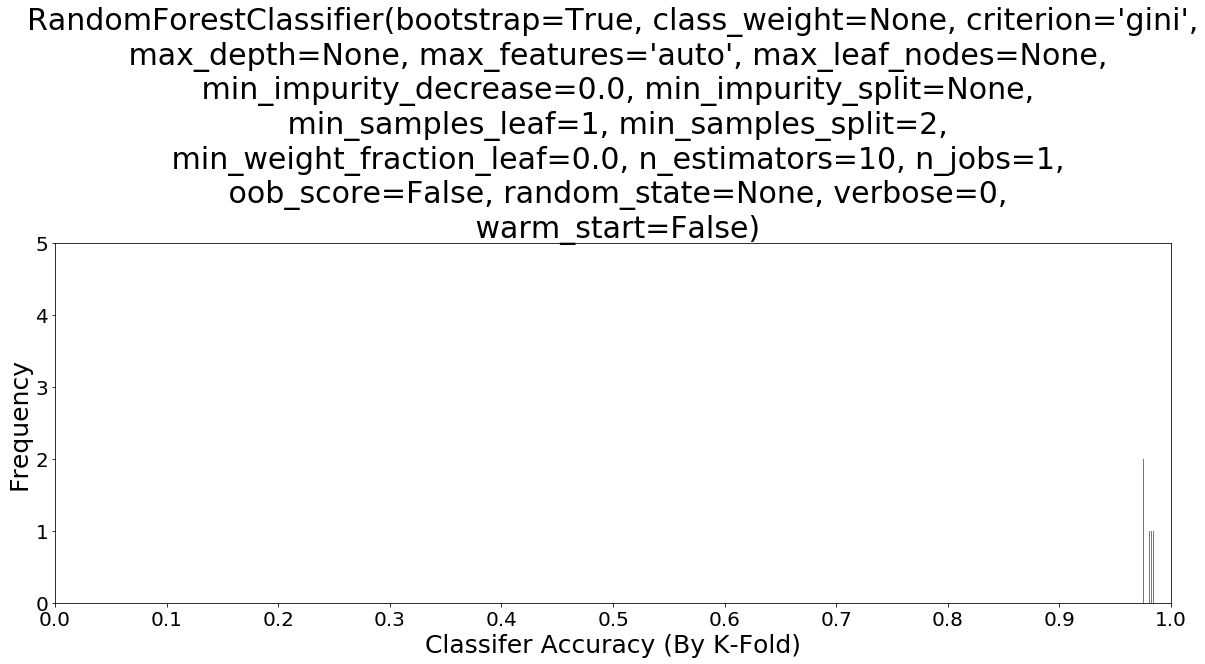

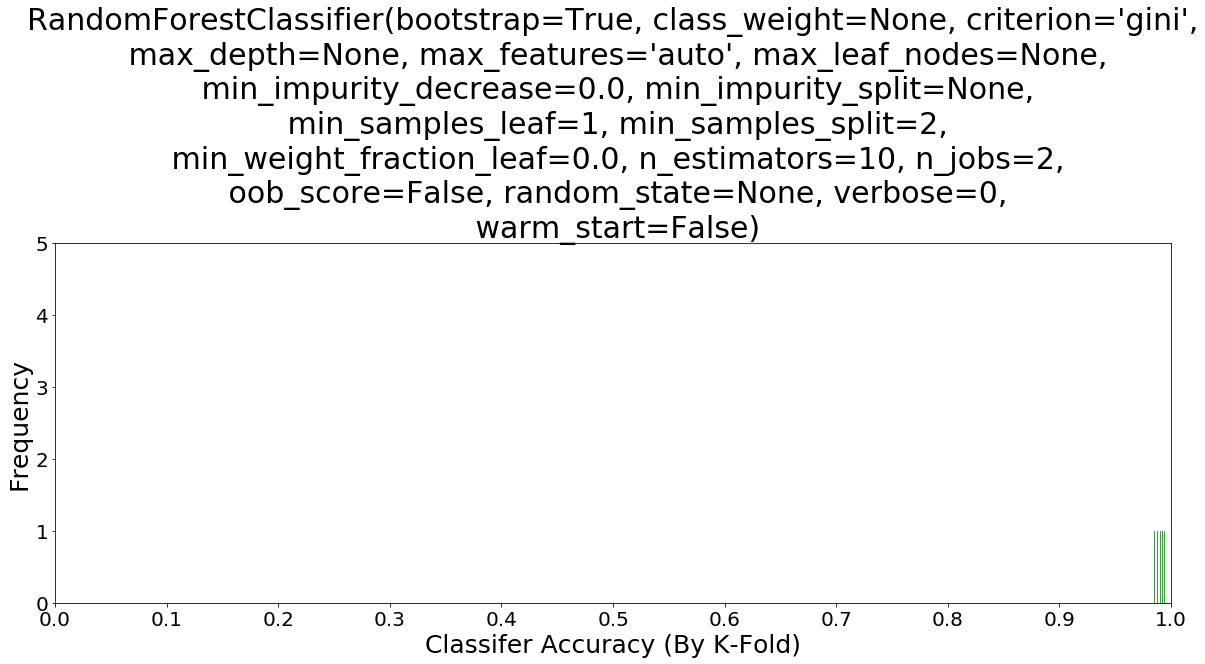

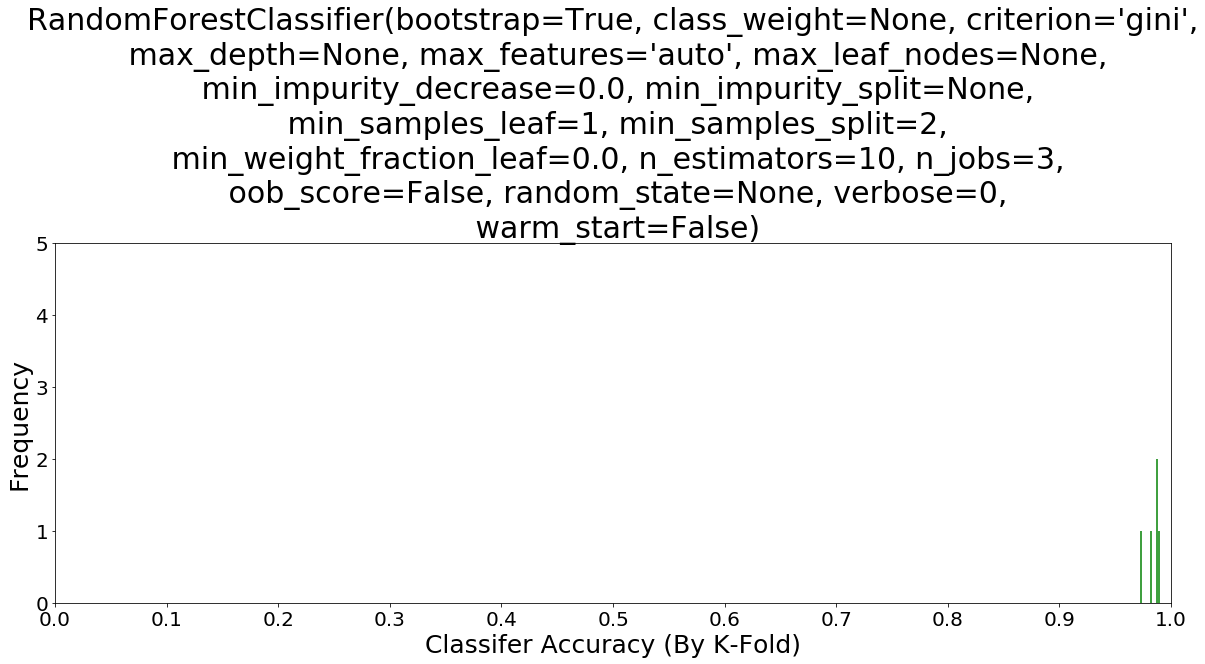

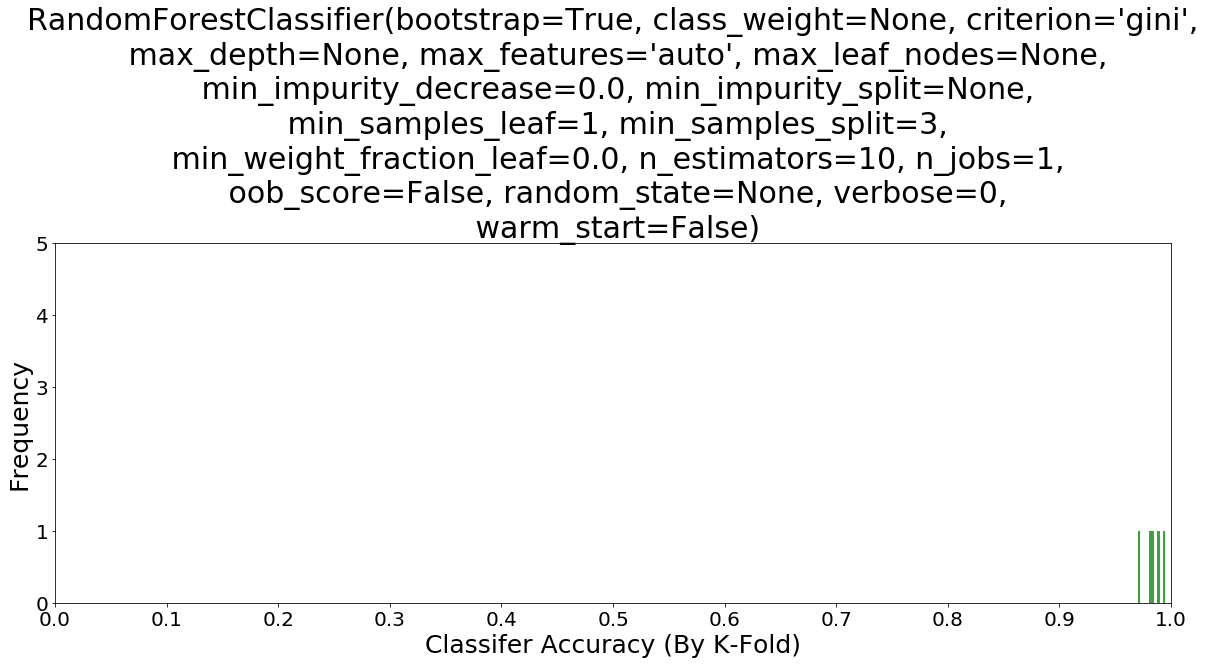

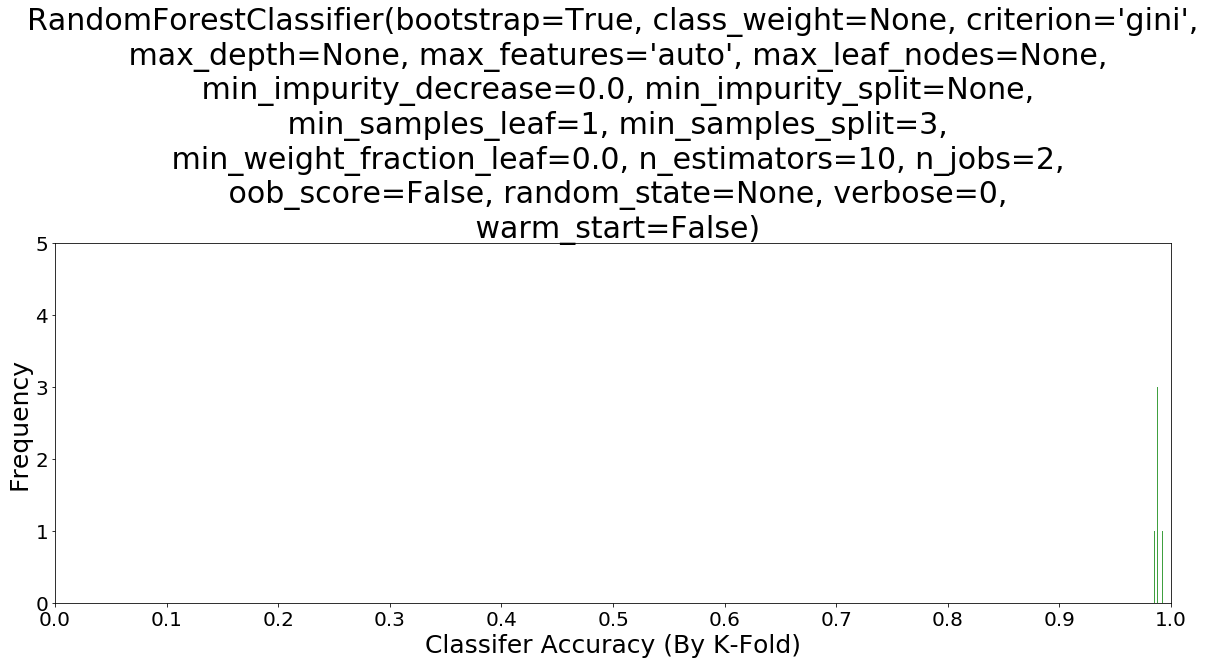

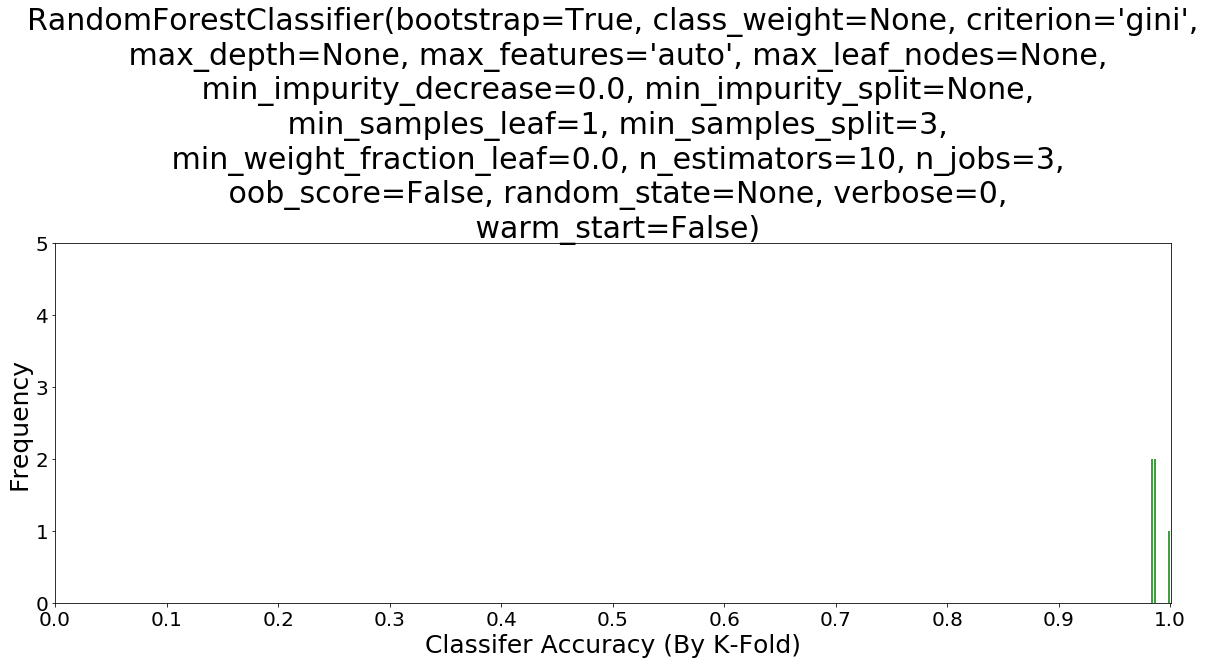

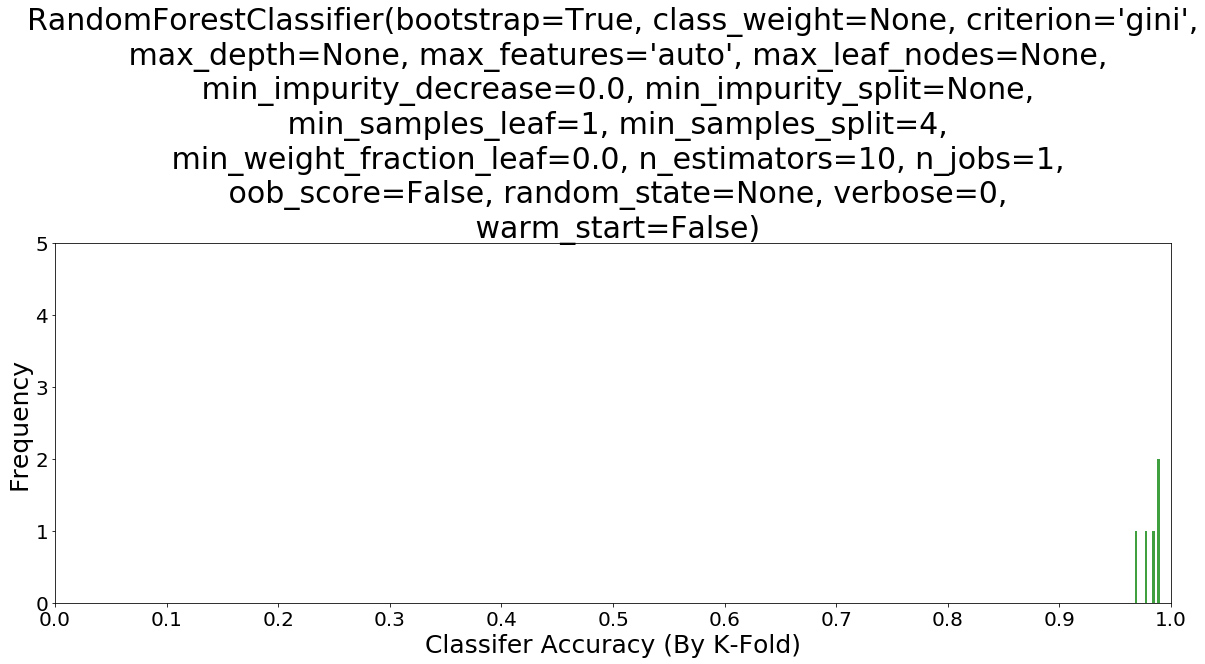

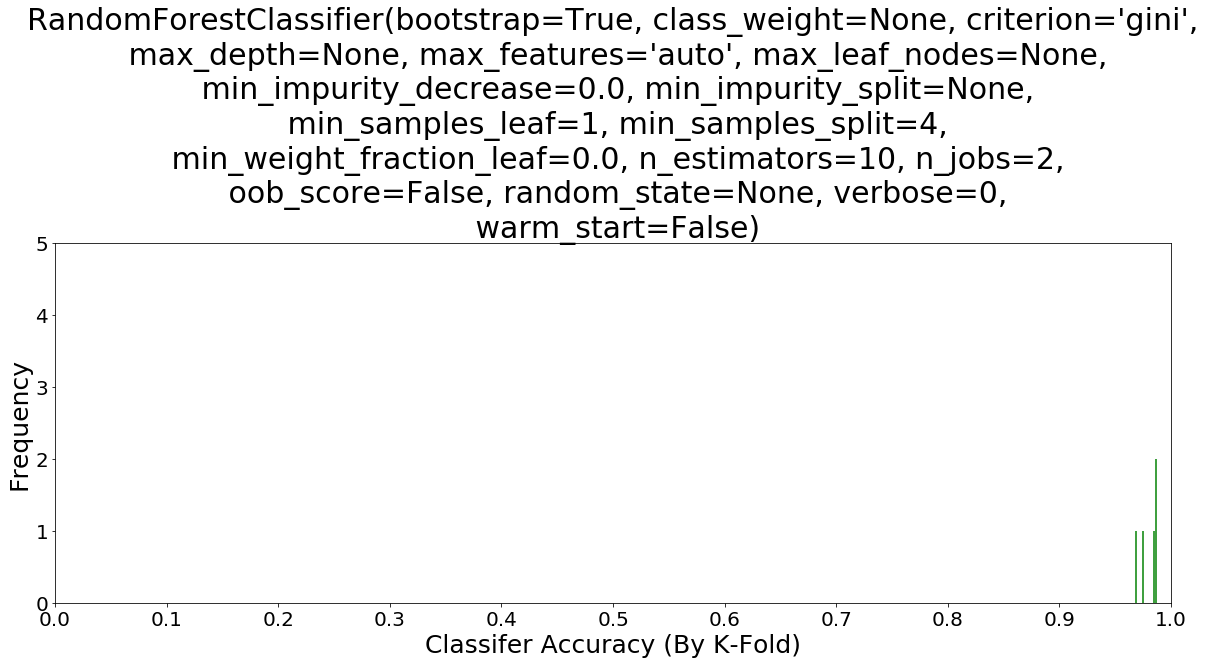

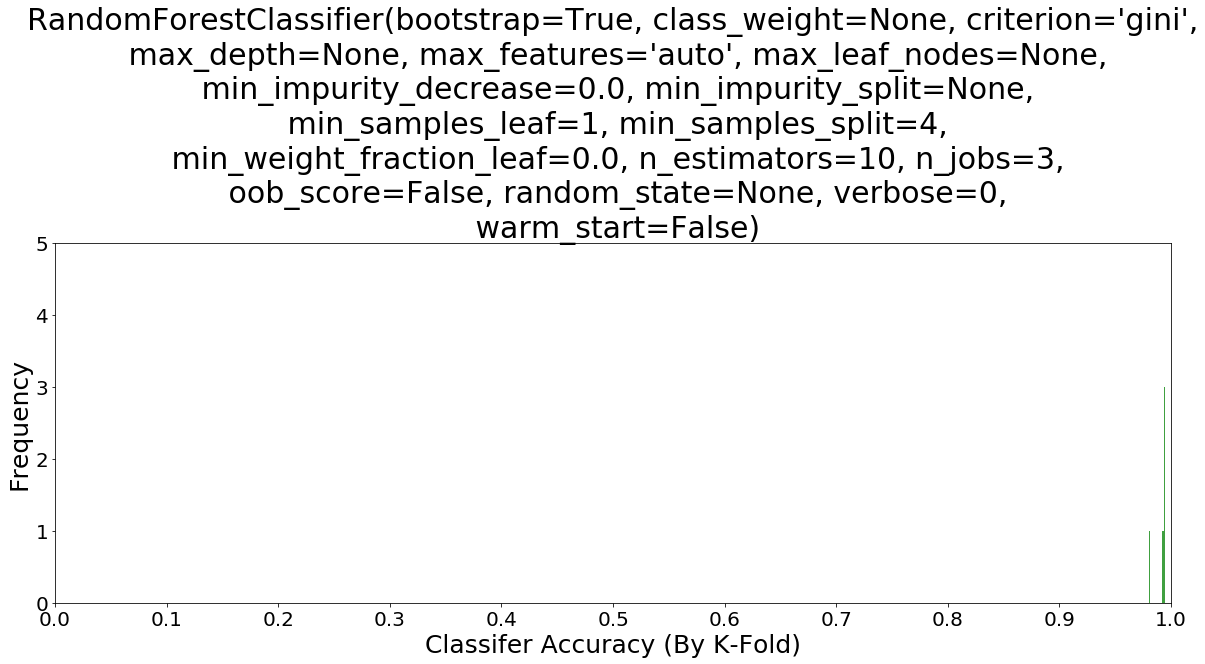

In [92]:
# for determining maximum frequency (# of kfolds) for histogram y-axis
n = max(len(v1) for k1, v1 in clfsAccuracyDict.items())

# for naming the plots
filename_prefix = 'clf_Histograms_'

# initialize the plot_num counter for incrementing in the loop below
plot_num = 1 

# Adjust matplotlib subplots for easy terminal window viewing
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.6      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for space between subplots,
               # expressed as a fraction of the average axis width
hspace = 0.2   # the amount of height reserved for space between subplots,
               # expressed as a fraction of the average axis height
               


#create the histograms
for k1, v1 in clfsAccuracyDict.items():
    # for each key in our clfsAccuracyDict, create a new histogram with a given key's values 
    fig = plt.figure(figsize =(20,10)) # This dictates the size of our histograms
    ax  = fig.add_subplot(1, 1, 1) # As the ax subplot numbers increase here, the plot gets smaller
    plt.hist(v1, facecolor='green', alpha=0.75) # create the histogram with the values
    ax.set_title(k1, fontsize=30) # increase title fontsize for readability
    ax.set_xlabel('Classifer Accuracy (By K-Fold)', fontsize=25) # increase x-axis label fontsize for readability
    ax.set_ylabel('Frequency', fontsize=25) # increase y-axis label fontsize for readability
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1)) # The accuracy can only be from 0 to 1 (e.g. 0 or 100%)
    ax.yaxis.set_ticks(np.arange(0, n+1, 1)) # n represents the number of k-folds
    ax.xaxis.set_tick_params(labelsize=20) # increase x-axis tick fontsize for readability
    ax.yaxis.set_tick_params(labelsize=20) # increase y-axis tick fontsize for readability
    #ax.grid(True) # you can turn this on for a grid, but I think it looks messy here.

    # pass in subplot adjustments from above.
    plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)
    plot_num_str = str(plot_num) #convert plot number to string
    filename = filename_prefix + plot_num_str # concatenate the filename prefix and the plot_num_str
    plt.savefig(filename, bbox_inches = 'tight') # save the plot to the user's working directory
    plot_num = plot_num+1 # increment the plot_num counter by 1
    
plt.show()